# EDA NYC Yellow Taxi – Khám phá dữ liệu

Mục tiêu:
- Nắm cấu trúc dữ liệu, tỷ lệ thiếu, phân phối các biến chính.
- Tạo feature thời gian (giờ, thứ, tháng), thời lượng chuyến đi, vận tốc ước tính.
- Phát hiện bất thường (timestamp ngược, giá âm, khoảng cách = 0 nhưng giá > 0, tốc độ phi lý).
- Xem phân bố theo danh mục (Vendor, Ratecode, Payment type) và tương quan giữa các biến số.

Hướng dẫn chạy:
1) Chạy ô đọc dữ liệu hiện có (ô 2) nếu kernel vừa khởi động.
2) Chạy lần lượt các ô EDA bên dưới (có ghi tiêu đề).

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ReadParquet").getOrCreate()
df = spark.read.parquet("/home/trung061204/Desktop/IT4931_Project/data/yellow_taxi/2025")
df.show()

ModuleNotFoundError: No module named 'pyspark'

In [3]:
count = df.count()
print(f"Number of rows: {count}")

df.describe().show()

Number of rows: 7052769


25/11/16 14:27:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/11/16 14:27:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/11/16 14:27:11 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|           VendorID|   passenger_count|    trip_distance|       RatecodeID|store_and_fwd_flag|      PULocationID|     DOLocationID|      payment_type|       fare_amount|             extra|           mta_tax|       tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+-------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+---------------------+-------------

In [4]:
# lấy 2% dữ liệu để khám phá
df = df.sample(False, 0.02)

print("Sample count:", df.count())

df.printSchema()

# check null
from pyspark.sql.functions import col, sum
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

# check categorical values
df.select("VendorID").distinct().show()
df.select("RatecodeID").distinct().show()
df.select("payment_type").distinct().show()

# check timestamp anomalies
df.filter(df.tpep_dropoff_datetime < df.tpep_pickup_datetime).show(5)

# summary statistics
df.describe().show()


Sample count: 141172
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)



+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|cbd_congestion_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       0|                   0|                    0|          26990|            0|     26990|             26990|           0|    

+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+------------------+--------------------+-------------------+-------------------+
|summary|          VendorID|   passenger_count|    trip_distance|        RatecodeID|store_and_fwd_flag|     PULocationID|      DOLocationID|      payment_type|      fare_amount|             extra|            mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|congestion_surcharge|        Airport_fee| cbd_congestion_fee|
+-------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+------------------+---------------------+----------

In [5]:
# === Thiết lập & helper ===
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, NumericType
import math

# Dùng df đã được load từ các ô phía trên
assert 'df' in globals(), "Vui lòng chạy ô đọc dữ liệu trước để tạo biến df"

# Chuẩn hóa tên cột pickup / dropoff để an toàn giữa các phiên bản schema
cols = df.columns
pickup_col = None
dropoff_col = None
for cand in ['tpep_pickup_datetime','pickup_datetime','lpep_pickup_datetime']:
    if cand in cols:
        pickup_col = cand
        break
for cand in ['tpep_dropoff_datetime','dropoff_datetime','lpep_dropoff_datetime']:
    if cand in cols:
        dropoff_col = cand
        break

if pickup_col is None or dropoff_col is None:
    raise ValueError("Không tìm thấy cột thời gian pickup/dropoff trong dataframe")

df_enriched = (
    df
    .withColumn("pickup_ts", F.col(pickup_col).cast("timestamp"))
    .withColumn("dropoff_ts", F.col(dropoff_col).cast("timestamp"))
    .withColumn("duration_min",
                (F.unix_timestamp(F.col("dropoff_ts")) - F.unix_timestamp(F.col("pickup_ts"))) / F.lit(60.0))
)

# Tốc độ (mph) = quãng đường (mile) / (thời lượng (giờ))
# Bảo vệ chia cho 0 hoặc âm
if 'trip_distance' in df_enriched.columns:
    df_enriched = df_enriched.withColumn(
        "speed_mph",
        F.when(F.col("duration_min") > 0, F.col("trip_distance") / (F.col("duration_min")/60.0))
         .otherwise(F.lit(None))
    )

# Feature thời gian
df_enriched = (
    df_enriched
    .withColumn("pickup_hour", F.hour("pickup_ts"))
    .withColumn("pickup_dow", F.dayofweek("pickup_ts"))  # 1=Chủ nhật trong Spark
    .withColumn("pickup_month", F.month("pickup_ts"))
)

# Cache và in schema nhanh
_ = df_enriched.cache()
df_enriched.printSchema()
print("Ví dụ 5 dòng:")
df_enriched.select(pickup_col, dropoff_col, *[c for c in ['trip_distance','fare_amount','total_amount'] if c in df_enriched.columns]).show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)
 |-- cbd_congestion_fee: double (nullable = true)
 |-- pickup_ts: timestamp (nullable = true)
 |-- dropoff_ts: timestamp (null

+--------------------+---------------------+-------------+-----------+------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|total_amount|
+--------------------+---------------------+-------------+-----------+------------+
| 2025-02-01 00:55:40|  2025-02-01 01:03:35|         1.65|       10.0|       16.75|
| 2025-02-01 00:13:32|  2025-02-01 00:21:34|         0.96|        9.3|       16.05|
| 2025-02-01 00:42:58|  2025-02-01 00:54:06|         2.39|       13.5|        23.1|
| 2025-02-01 00:21:45|  2025-02-01 00:33:59|          2.5|       13.5|        23.1|
| 2025-02-01 00:46:50|  2025-02-01 00:51:30|          0.6|        5.8|       13.85|
+--------------------+---------------------+-------------+-----------+------------+
only showing top 5 rows



In [6]:
# === Thiếu dữ liệu (null/NaN/chuỗi rỗng) ===
from pyspark.sql.types import DoubleType, FloatType, IntegerType, LongType, ShortType, DecimalType, BooleanType

total = df_enriched.count()
exprs = []
for f in df_enriched.schema.fields:
    c = f.name
    dt = f.dataType
    if isinstance(dt, StringType):
        # đếm null hoặc chuỗi rỗng
        exprs.append(F.sum(F.when(F.col(c).isNull() | (F.col(c) == ''), 1).otherwise(0)).alias(c))
    elif isinstance(dt, (DoubleType, FloatType, IntegerType, LongType, ShortType, DecimalType)):
        exprs.append(F.sum(F.when(F.col(c).isNull() | F.isnan(c), 1).otherwise(0)).alias(c))
    else:
        exprs.append(F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c))

missing_row = df_enriched.select(exprs).collect()[0].asDict()
missing_list = [(k, int(v), round((int(v)/total)*100, 2)) for k, v in missing_row.items()]
missing_df = spark.createDataFrame(missing_list, ['column', 'missing_count', 'missing_pct'])
missing_df.orderBy(F.desc('missing_count')).show(100, truncate=False)

+---------------------+-------------+-----------+
|column               |missing_count|missing_pct|
+---------------------+-------------+-----------+
|Airport_fee          |26990        |19.12      |
|passenger_count      |26990        |19.12      |
|store_and_fwd_flag   |26990        |19.12      |
|RatecodeID           |26990        |19.12      |
|congestion_surcharge |26990        |19.12      |
|speed_mph            |152          |0.11       |
|DOLocationID         |0            |0.0        |
|tpep_dropoff_datetime|0            |0.0        |
|payment_type         |0            |0.0        |
|PULocationID         |0            |0.0        |
|duration_min         |0            |0.0        |
|tolls_amount         |0            |0.0        |
|pickup_hour          |0            |0.0        |
|improvement_surcharge|0            |0.0        |
|trip_distance        |0            |0.0        |
|pickup_dow           |0            |0.0        |
|VendorID             |0            |0.0        |


In [7]:
# === Phân phối biến phân loại ===
cat_cols = [c for c in ['VendorID','RatecodeID','payment_type','passenger_count','store_and_fwd_flag'] if c in df_enriched.columns]
for c in cat_cols:
    print(f"\nTop giá trị của {c}:")
    (df_enriched.groupBy(c).count().orderBy(F.desc('count')).show(20))


Top giá trị của VendorID:
+--------+------+
|VendorID| count|
+--------+------+
|       2|110978|
|       1| 30060|
|       7|   110|
|       6|    24|
+--------+------+


Top giá trị của RatecodeID:
+----------+------+
|RatecodeID| count|
+----------+------+
|         1|107573|
|      NULL| 26990|
|         2|  3491|
|        99|  1562|
|         5|   958|
|         3|   329|
|         4|   269|
+----------+------+


Top giá trị của payment_type:
+--------+------+
|VendorID| count|
+--------+------+
|       2|110978|
|       1| 30060|
|       7|   110|
|       6|    24|
+--------+------+


Top giá trị của RatecodeID:
+----------+------+
|RatecodeID| count|
+----------+------+
|         1|107573|
|      NULL| 26990|
|         2|  3491|
|        99|  1562|
|         5|   958|
|         3|   329|
|         4|   269|
+----------+------+


Top giá trị của payment_type:
+------------+-----+
|payment_type|count|
+------------+-----+
|           1|95573|
|           0|26990|
|           2|14

Numeric columns dùng để vẽ: ['trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'duration_min', 'speed_mph']
Pandas sample size: 1382


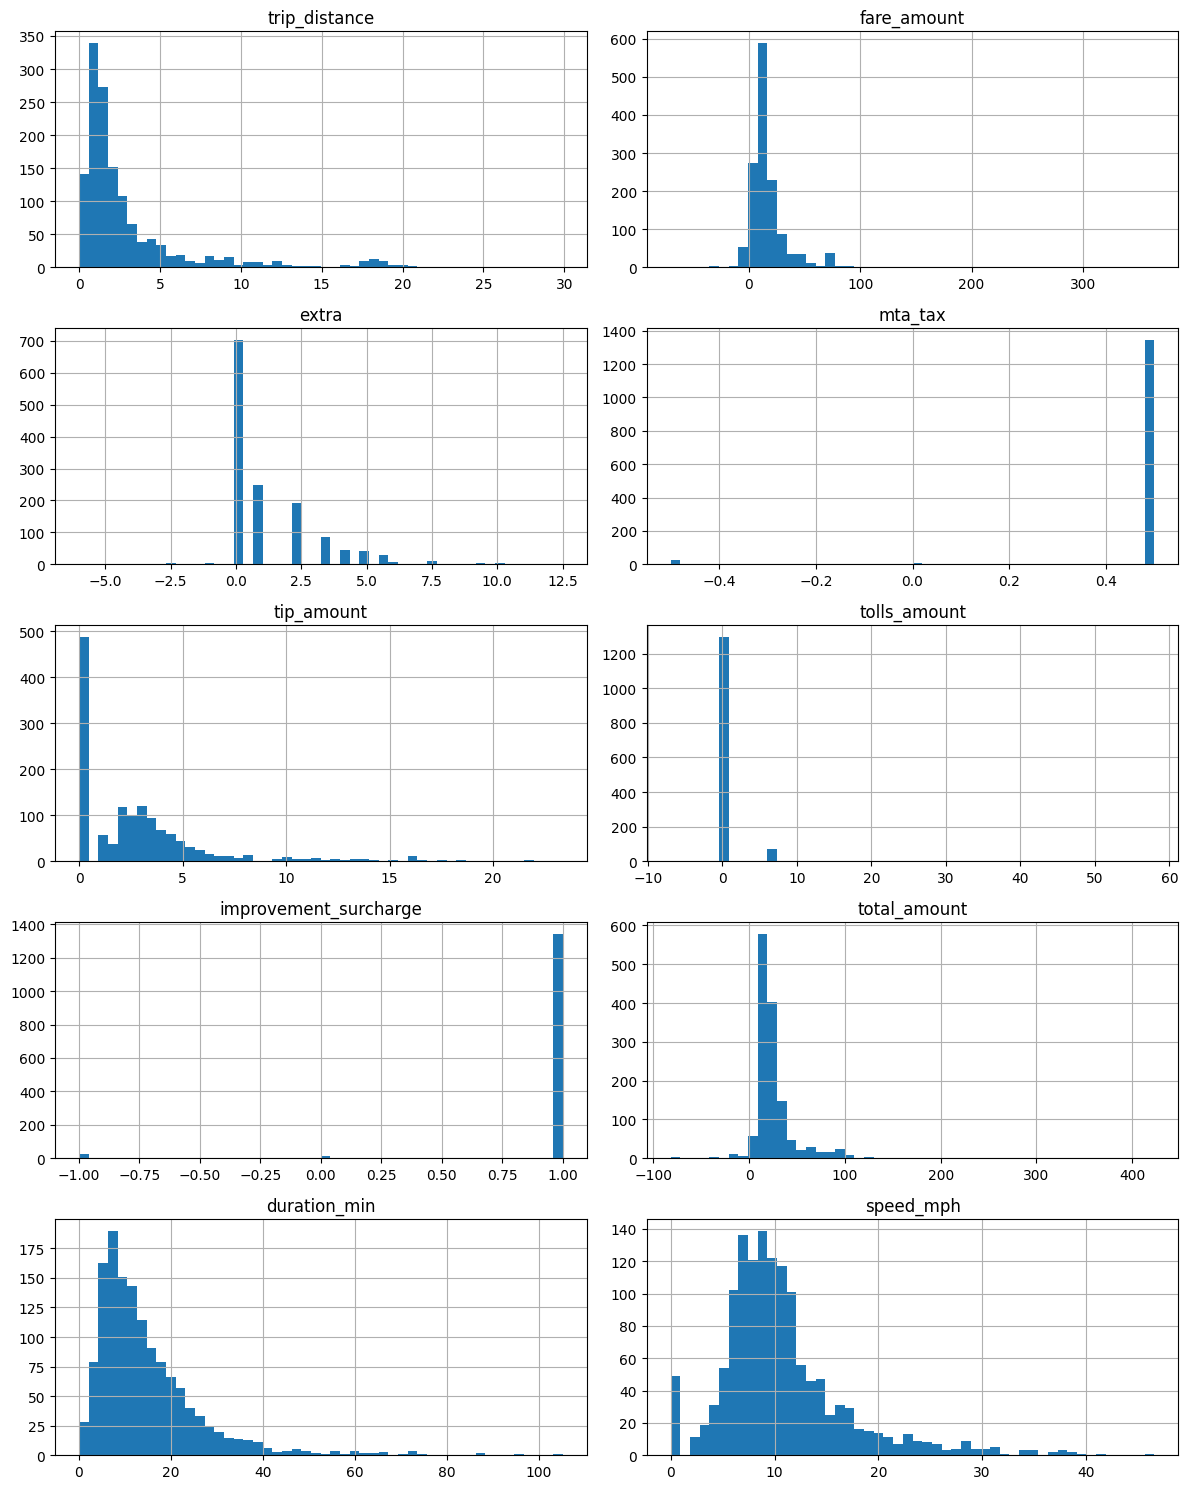

In [9]:
# === Phân phối biến số (histograms) ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

numeric_candidates = ['trip_distance','fare_amount','extra','mta_tax','tip_amount','tolls_amount','improvement_surcharge','total_amount','duration_min','speed_mph']
num_cols = [c for c in numeric_candidates if c in df_enriched.columns]
print("Numeric columns dùng để vẽ:", num_cols)

sample_for_pd = (df_enriched
                   .select(*num_cols)
                   .dropna()
                   .sample(False, 0.01, seed=42)
                   .limit(50000))
pdf = sample_for_pd.toPandas()
print("Pandas sample size:", len(pdf))

n = len(num_cols)
rows = math.ceil(n/2)
cols = 2 if n > 1 else 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 3*rows))
axes = np.array(axes).reshape(-1) if n > 1 else np.array([axes])
for i, c in enumerate(num_cols):
    ax = axes[i]
    pdf[c].hist(bins=50, ax=ax)
    ax.set_title(c)
plt.tight_layout()
plt.show()

In [10]:
# === Pattern theo thời gian (giờ / thứ / tháng) ===
tip_col = 'tip_amount' if 'tip_amount' in df_enriched.columns else None
total_col = 'total_amount' if 'total_amount' in df_enriched.columns else None

def show_time_group(key):
    aggs = {
        'rides': F.count(F.lit(1))
    }
    if 'fare_amount' in df_enriched.columns:
        aggs['avg_fare'] = F.avg('fare_amount')
    if tip_col and total_col:
        aggs['avg_tip_pct'] = F.avg(F.when(F.col(total_col) > 0, F.col(tip_col)/F.col(total_col)).otherwise(None))
    (df_enriched
     .groupBy(key)
     .agg(*[v.alias(k) for k, v in aggs.items()])
     .orderBy(key)
     .show(50, truncate=False))

print("Theo giờ:")
show_time_group('pickup_hour')

print("\nTheo thứ (1=CN -> 7=Thứ 7):")
show_time_group('pickup_dow')

print("\nTheo tháng:")
show_time_group('pickup_month')

Theo giờ:
+-----------+-----+------------------+-------------------+
|pickup_hour|rides|avg_fare          |avg_tip_pct        |
+-----------+-----+------------------+-------------------+
|0          |4050 |16.95276049382716 |0.08061272291814903|
|1          |2696 |15.123979970326406|0.08118625865779802|
|2          |1863 |15.366054750402578|0.08208091618862368|
|3          |1246 |15.517800963081863|0.08092751365810812|
|4          |867  |19.812168396770474|0.07309105265160712|
|5          |961  |23.435525494276792|0.07284451205627036|
|6          |1971 |19.093784880771185|0.0803265862571503 |
|7          |4006 |17.242014478282584|0.09446943717815544|
|8          |5598 |16.501693461950698|0.09743900215907494|
|9          |5676 |16.315828047921073|0.10927248949996826|
|10         |5851 |16.70750128183217 |0.11316054180401516|
|11         |6166 |16.19897988971781 |0.11336545879237046|
|12         |6902 |16.694030715734577|0.11170471194431088|
|13         |7361 |16.624722184485805|0.113070

In [12]:
# === Kiểm tra bất thường / dữ liệu bẩn ===
anomaly_checks = {}

# 1) Timestamp ngược
anomaly_checks['reversed_time'] = df_enriched.filter(F.col('dropoff_ts') < F.col('pickup_ts')).count()

# 2) Khoảng cách âm / = 0
if 'trip_distance' in df_enriched.columns:
    anomaly_checks['non_positive_distance'] = df_enriched.filter(F.col('trip_distance') <= 0).count()

# 3) Tiền âm hoặc = 0
for c in ['fare_amount','tip_amount','tolls_amount','total_amount']:
    if c in df_enriched.columns:
        anomaly_checks[f'non_positive_{c}'] = df_enriched.filter(F.col(c) <= 0).count()

# 4) Tốc độ phi lý (> 100 mph)
if 'speed_mph' in df_enriched.columns:
    anomaly_checks['speed_gt_100mph'] = df_enriched.filter(F.col('speed_mph') > 100).count()

print("Tổng quan bất thường:")
for k, v in anomaly_checks.items():
    print(f"- {k}: {v}")

# Hiển thị vài dòng ví dụ
print("\nVí dụ timestamp ngược:")
df_enriched.filter(F.col('dropoff_ts') < F.col('pickup_ts')).select(pickup_col, dropoff_col, 'trip_distance', 'fare_amount', 'duration_min').show(5)

if 'trip_distance' in df_enriched.columns:
    print("\nVí dụ distance <= 0:")
    df_enriched.filter(F.col('trip_distance') <= 0).select(pickup_col, dropoff_col, 'trip_distance', 'fare_amount', 'total_amount').show(5)

if 'speed_mph' in df_enriched.columns:
    print("\nVí dụ speed > 100 mph:")
    df_enriched.filter(F.col('speed_mph') > 100).select(pickup_col, dropoff_col, 'trip_distance', 'duration_min', 'speed_mph').show(5)

Tổng quan bất thường:
- reversed_time: 9
- non_positive_distance: 3889
- non_positive_fare_amount: 6755
- non_positive_tip_amount: 48957
- non_positive_tolls_amount: 133001
- non_positive_total_amount: 2458
- speed_gt_100mph: 26

Ví dụ timestamp ngược:
+--------------------+---------------------+-------------+-----------+--------------------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|fare_amount|        duration_min|
+--------------------+---------------------+-------------+-----------+--------------------+
| 2025-01-08 15:01:54|  2025-01-08 15:01:15|         9.66|        2.9|               -0.65|
| 2025-01-14 06:01:37|  2025-01-14 06:01:28|         8.73|        2.9|               -0.15|
| 2025-01-16 13:01:15|  2025-01-16 13:01:10|          8.0|        2.9|-0.08333333333333333|
| 2025-02-19 07:02:49|  2025-02-19 07:02:25|         2.91|        2.9|                -0.4|
| 2025-01-19 16:01:39|  2025-01-19 16:01:03|         0.49|        2.9|                -0.6|
+----------

Corr sample size: 1176 cols: ['trip_distance', 'fare_amount', 'tip_amount', 'tolls_amount', 'total_amount', 'duration_min', 'speed_mph', 'passenger_count']


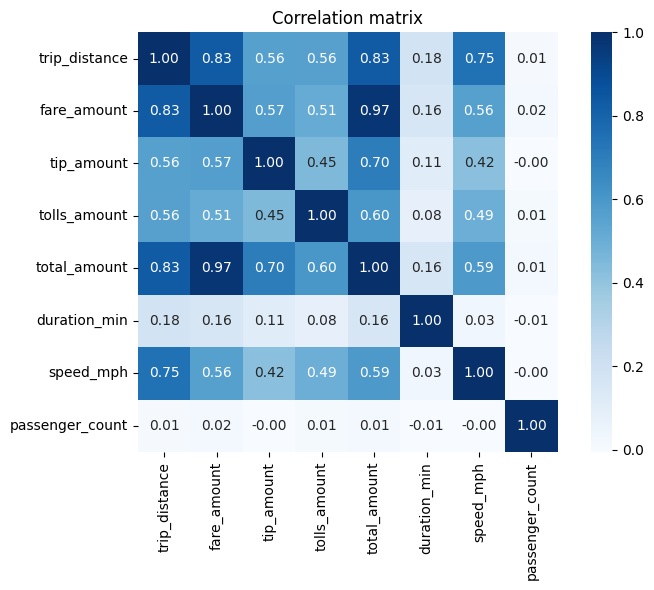

In [13]:
# === Tương quan giữa các biến số ===
try:
    import seaborn as sns
    _has_sns = True
except Exception:
    import matplotlib.pyplot as plt
    _has_sns = False
import matplotlib.pyplot as plt

corr_candidates = ['trip_distance','fare_amount','tip_amount','tolls_amount','total_amount','duration_min','speed_mph','passenger_count']
corr_cols = [c for c in corr_candidates if c in df_enriched.columns]
pdf_corr = (df_enriched
             .select(*corr_cols)
             .dropna()
             .sample(False, 0.01, seed=7)
             .limit(30000)
            ).toPandas()
print("Corr sample size:", len(pdf_corr), "cols:", corr_cols)
if len(pdf_corr) > 0 and len(corr_cols) > 1:
    corr = pdf_corr.corr(numeric_only=True)
    plt.figure(figsize=(8,6))
    if _has_sns:
        sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', square=True)
    else:
        plt.imshow(corr, cmap='Blues')
        plt.colorbar()
        plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right')
        plt.yticks(range(len(corr_cols)), corr_cols)
        for i in range(len(corr_cols)):
            for j in range(len(corr_cols)):
                plt.text(j, i, f"{corr.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    plt.title('Correlation matrix')
    plt.tight_layout()
    plt.show()
else:
    print("Không đủ dữ liệu/biến để tính tương quan")

## Gợi ý kết luận & bước tiếp theo

- Kiểm tra tỷ lệ thiếu và quyết định chiến lược: loại bỏ một phần, hoặc điền (impute) có điều kiện theo thời gian/khu vực.
- Lọc dữ liệu bẩn: timestamp ngược, khoảng cách <= 0, giá âm; có thể loại bỏ hoặc gắn cờ để phân tích riêng.
- Quy chuẩn outlier: tốc độ quá cao, fare quá cao/âm; dùng IQR hoặc winsorization nếu cần.
- Tận dụng feature thời gian (giờ, thứ, tháng) để tạo seasonal profile; thêm holiday/ thời tiết nếu có.
- Cho mô hình: cân nhắc feature tipping (tip_pct), tốc độ, thời lượng, và tương tác (hour x dow).

Nếu bạn muốn, mình có thể tách các rule làm sạch thành job Spark riêng (`src/spark_jobs/`) và lưu parquet “đã làm sạch” cho downstream.